In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
from matplotlib import gridspec


from costools import splittag
import calcos

import glob
import os
from pathlib import Path

from astroquery.mast import Observations

import warnings
from astropy.units import UnitsWarning

The following tasks in the costools package can be run with TEAL:
         splittag                 timefilter                 x1dcorr


In [2]:
output_dir = Path('./output/')
plots_dir = output_dir / 'plots'
output_dir.mkdir(exist_ok=True), plots_dir.mkdir(exist_ok=True)

(None, None)

In [3]:
# Find all MAST data on this obs id:
pl = Observations.get_product_list(Observations.query_criteria(obs_id='lf0a01010'))

# Filter and download the Corrtag TIME-TAG files:
pl_filt = Observations.filter_products(
    pl, productSubGroupDescription=('CORRTAG_A', 'CORRTAG_B')
)
downloaded_corrtags = Observations.download_products(pl_filt)['Local Path']

# Filter and download the extracted spectra (X1D) files:
pl_filt = Observations.filter_products(
    pl, productSubGroupDescription=('X1D')
)
downloaded_x1ds = Observations.download_products(pl_filt)['Local Path']

# Let us know how many corrtags were found:
print(
    f"#####\nFound {len(downloaded_corrtags)} corrtag exposure files from the COS FUV detector (segment A only)")

INFO: Found cached file .\mastDownload\HST\lf0a01awq\lf0a01awq_corrtag_a.fits with expected size 14889600. [astroquery.query]
INFO: Found cached file .\mastDownload\HST\lf0a01ayq\lf0a01ayq_corrtag_a.fits with expected size 20249280. [astroquery.query]
INFO: Found cached file .\mastDownload\HST\lf0a01b0q\lf0a01b0q_corrtag_a.fits with expected size 14353920. [astroquery.query]
INFO: Found cached file .\mastDownload\HST\lf0a01b5q\lf0a01b5q_corrtag_a.fits with expected size 24177600. [astroquery.query]
INFO: Found cached file .\mastDownload\HST\lf0a01awq\lf0a01awq_x1d.fits with expected size 1719360. [astroquery.query]
INFO: Found cached file .\mastDownload\HST\lf0a01ayq\lf0a01ayq_x1d.fits with expected size 1719360. [astroquery.query]
INFO: Found cached file .\mastDownload\HST\lf0a01b0q\lf0a01b0q_x1d.fits with expected size 1719360. [astroquery.query]
INFO: Found cached file .\mastDownload\HST\lf0a01b5q\lf0a01b5q_x1d.fits with expected size 1719360. [astroquery.query]
#####
Found 4 corrta

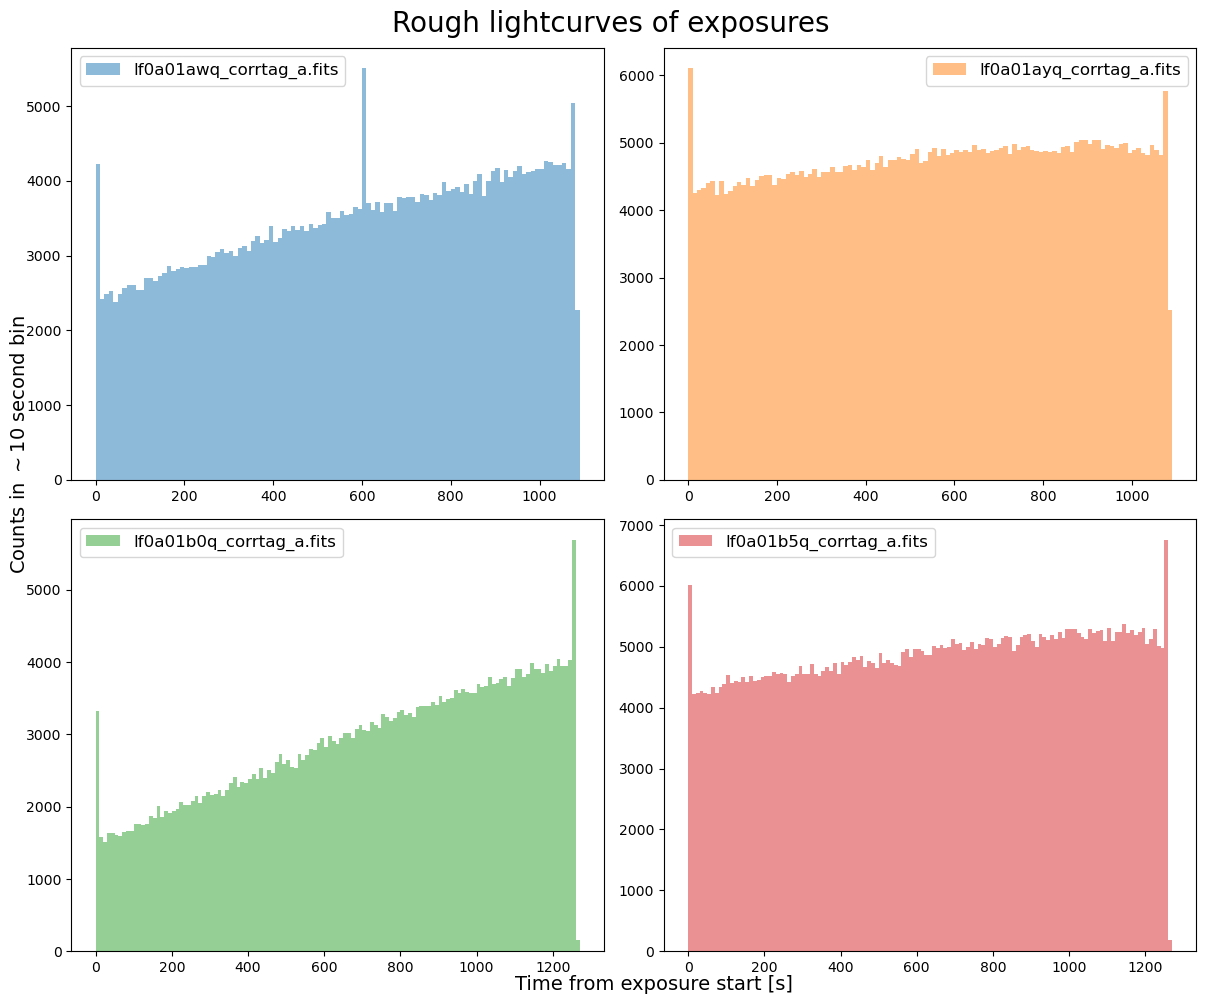

In [4]:
# Build the figure structure
fig = plt.figure(figsize=(12, 10))
# Using gridspec to let us control panel sizes and locations
gs = fig.add_gridspec(nrows=2, ncols=2)
# Get the time data for each exposure
binsize = 10  # Number of seconds in a bin
for i, ctag in enumerate(downloaded_corrtags):
    ax = fig.add_subplot(gs[int(i/2), i % 2])  # make the subplot
    ctab = Table.read(ctag, 1)  # read the data into a table
    event_times = ctab['TIME']
    # plot the histogram of times
    hist = ax.hist(
        event_times,
        bins=np.arange(0, max(event_times)+binsize, binsize),
        alpha=0.5, 
        label=os.path.basename(ctag),
        color=['C0', 'C1', 'C2', 'C3'][i]
    )
    plt.legend(fontsize=12)
# Format the figure and add text:
plt.suptitle("Rough lightcurves of exposures", fontsize=20)
fig.text(
    x=0.42, y=-0.0001,
    s="Time from exposure start [s]",
    fontsize=14
)
fig.text(
    y=0.42, x=-0.001,
    s=f"Counts in $\sim${binsize} second bin",
    rotation='vertical',
    fontsize=14
)
plt.tight_layout()
plt.savefig(plots_dir / 'compare_exposures.png', bbox_inches='tight', dpi=200)

The length of the exposure is ~1260 s


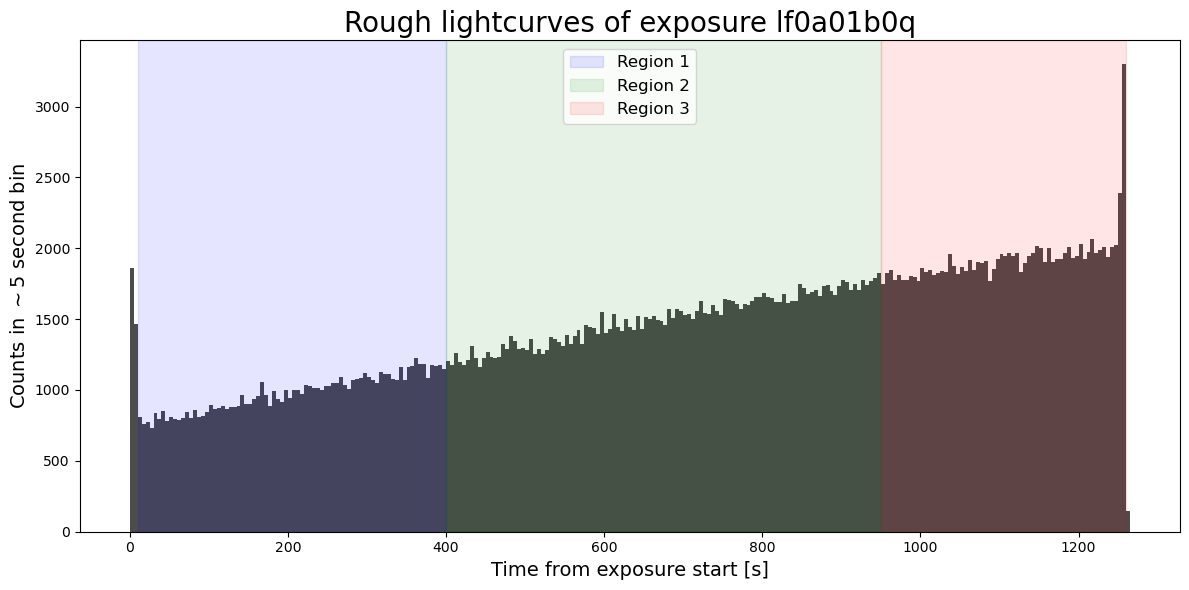

In [5]:
# Find the path to the right exposure
target_exp = [exp for exp in downloaded_corrtags if "b0q" in exp][0]
target_basename = os.path.basename(target_exp).split('_')[0]

# Create the plot:
fig = plt.figure(figsize=(12, 6))

# Select the data and plot it:
binsize = 5 # Binsize in seconds
ctab = Table.read(target_exp, 1)
event_times = ctab['TIME']
hist = plt.hist(event_times, bins=np.arange(0, max(event_times)+binsize, binsize),
                color='k', alpha=0.7)

# Add time ranges "epochs" or "windows of time" as transparent spans:
epoch_markers = [(10, 400), (400, 950), (950, max(event_times))]
print(f"The length of the exposure is ~{int(max(event_times))} s")
epoch_labels = ["Region 1", "Region 2", "Region 3"]
for epoch_time, epoch_label, color in zip(epoch_markers, epoch_labels, "bgr"):
    plt.axvspan(
        epoch_time[0], epoch_time[1],
        color=color, alpha=0.1, label=epoch_label
    )

# Format the Figure
plt.legend(fontsize=12)
plt.title(f"Rough lightcurves of exposure {target_basename}",
          size=20)
plt.xlabel("Time from exposure start [s]",
           fontsize=14)
plt.ylabel(f"Counts in $\sim${binsize} second bin",
           fontsize=14)
plt.tight_layout()
plt.savefig(plots_dir / 'examine_different_regions.png', bbox_inches='tight', dpi=200)

In [6]:
# Make the folder in which to store the newly split corrtag files:
spec_int_dir = output_dir / 'spec_intervals'
# An output directory for files split on specified intervals
spec_int_dir.mkdir(exist_ok=True)

# Use CAUTION when deleting files - as in the next lines
# These lines delete existing processed files in the output directory
#   if you have run this cell before, this will overwrite previous outputs
delete_old_files = True
if delete_old_files and any(spec_int_dir.glob("*corrtag*fits")):
    print("Deleting files from a previous run...")
    [old_file.unlink() for old_file in list(spec_int_dir.glob("*corrtag*fits"))]

# Print info to the user:
print("Creating and writing split files...")
for i, epoch_times in enumerate(epoch_markers):
    print(
        f"> File {i+1} contains counts from time:",
        f"{epoch_times[0]} - {epoch_times[1]} seconds"
    )
split_list = [10, 400, 950, 1220]
# Run splittag using our specified times:
splittag.splittag(infiles=target_exp,
                  outroot=f'./output/spec_intervals/{target_basename}',
                  time_list=split_list)

Deleting files from a previous run...
Creating and writing split files...
> File 1 contains counts from time: 10 - 400 seconds
> File 2 contains counts from time: 400 - 950 seconds
> File 3 contains counts from time: 950 - 1260.1920166015625 seconds


./output/spec_intervals/lf0a01b0q_1_corrtag_a.fits written
./output/spec_intervals/lf0a01b0q_2_corrtag_a.fits written
./output/spec_intervals/lf0a01b0q_3_corrtag_a.fits written


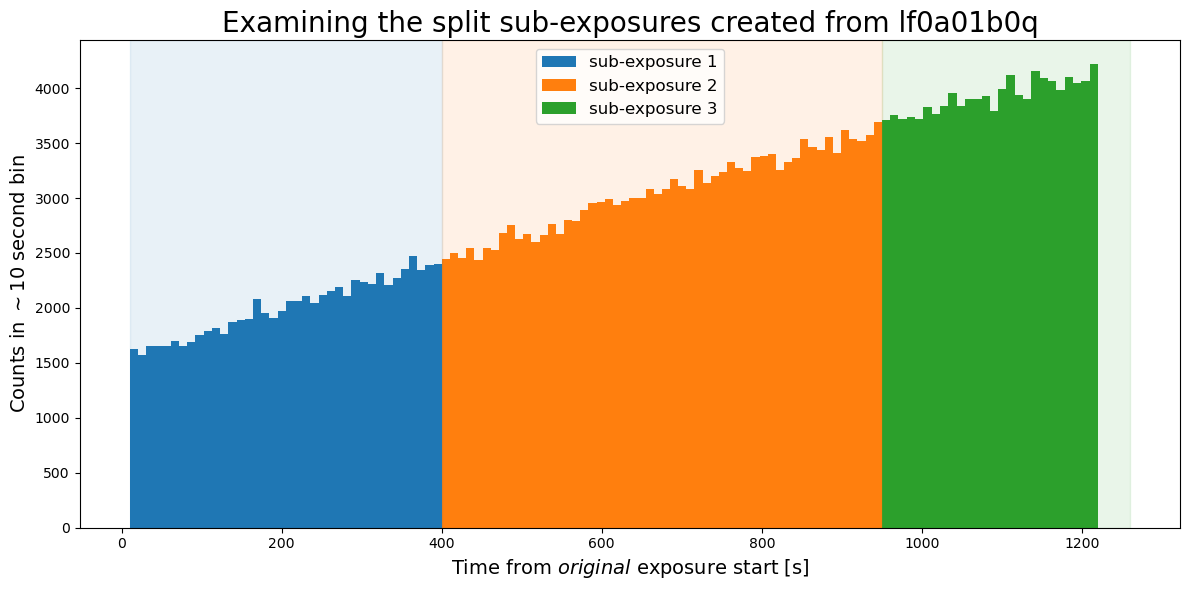

In [7]:
# Create the plot:
fig = plt.figure(figsize=(12, 6))

# Gather the split sub-exposure files:
spec_outlist = sorted(glob.glob('./output/spec_intervals/*fits'))

# Make histogram lightcurves as in previous plots:
binsize = 10 # binsize of lightcurve histogram in seconds
for splitfile in spec_outlist:  # For each of our newly split up files:
    epoch_number = os.path.basename(splitfile).split('_')[1]
    # Read in the file as a table of events:
    events_table = Table.read(splitfile, 1)
    event_times = events_table['TIME']
    hist = plt.hist(
        event_times,
        bins=int((max(event_times)-min(event_times))/binsize),
        alpha=1, label=f"sub-exposure {epoch_number}"
    )

# Add time ranges "epochs" or "windows of time" as transparent spans:
for epoch_time, color in zip(epoch_markers, ['C0', 'C1', 'C2']):
    plt.axvspan(
        epoch_time[0], epoch_time[1],
        color=color, alpha=0.1, label=None
    )

# Format the Figure
plt.legend(fontsize=12)
plt.title(f"Examining the split sub-exposures created from {target_basename}",
          size=20)
plt.xlabel("Time from $original$ exposure start [s]",
           fontsize=14)
plt.ylabel(f"Counts in $\sim${binsize} second bin",
           fontsize=14)
plt.tight_layout()
plt.savefig(plots_dir / 'subexps.png', bbox_inches='tight', dpi=200)

In [8]:
os.environ['lref'] = 'C:\\Users\\serat\\Downloads\\manual'


found_lref = Path(os.environ.get('lref'))
print(f"You already have an lref path in your environment variables - It's {found_lref}\n")

You already have an lref path in your environment variables - It's C:\Users\serat\Downloads\manual



In [9]:
for split_corrtag in spec_outlist:  # When we run CalCOS on corrtags, we must go 1-by-1
    # Define epoch as which chunk of the initial exposure.
    epoch_number = os.path.basename(split_corrtag).split('_')[1]
    print(f"Extracting file {split_corrtag} using CalCOS")
    # Make a sub-directory of output/calcos/ named for each epoch:
    cal_output_dir = f'./output/calcos/epoch{epoch_number}/'
    os.makedirs(cal_output_dir, exist_ok=True)
    # Extract the spectrum from each of the sub-exposures:
    calcos.calcos(split_corrtag, outdir=cal_output_dir, verbosity=0)
# Print a message at the end to let us know it's finished:
print("Done running the pipeline.")

Extracting file ./output/spec_intervals\lf0a01b0q_1_corrtag_a.fits using CalCOS
CALCOS version 3.4.8
numpy version 1.24.3
astropy version 5.1
Begin 11-Jun-2024 13:07:08 Bangladesh Standard Time
Don't add simulated wavecal because association has no exp_swave members
Shifting to -2, -5
Shifting to -1, -5
Shifting to -2, -5
Shifting to -1, -5
Shifting to -2, -4
Shifting to -1, -4
Shifting to -2, -4
Shifting to -1, -4
Shifting to -2, -3
Shifting to -1, -3
Shifting to -2, -3
Shifting to -1, -3
Shifting to -2, -2
Shifting to -1, -2
Shifting to -2, -2
Shifting to -1, -2
Shifting to -2, -1
Shifting to -1, -1
Shifting to -2, -1
Shifting to -1, -1
Shifting to -2, 0
Shifting to -1, 0
Shifting to -2, 0
Shifting to -1, 0
Shifting to -2, 1
Shifting to -1, 1
Shifting to -2, 1
Shifting to -1, 1
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 463.884507
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region

['output/calcos\\epoch1\\lf0a01b0q_1_x1d.fits', 'output/calcos\\epoch2\\lf0a01b0q_2_x1d.fits', 'output/calcos\\epoch3\\lf0a01b0q_3_x1d.fits']


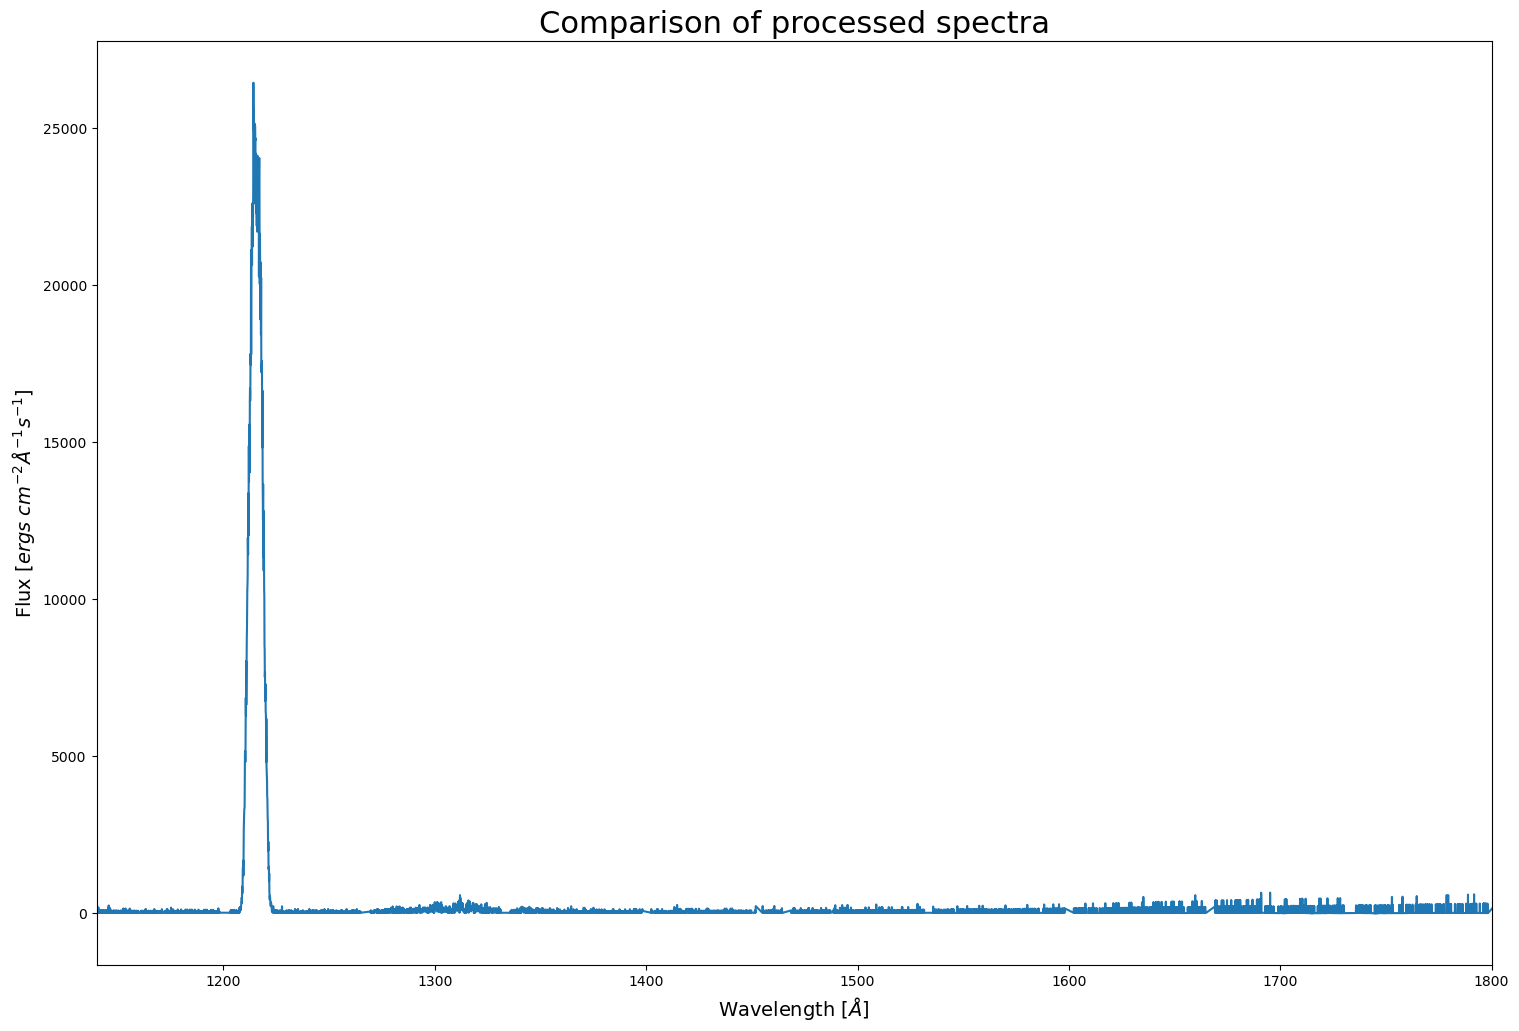

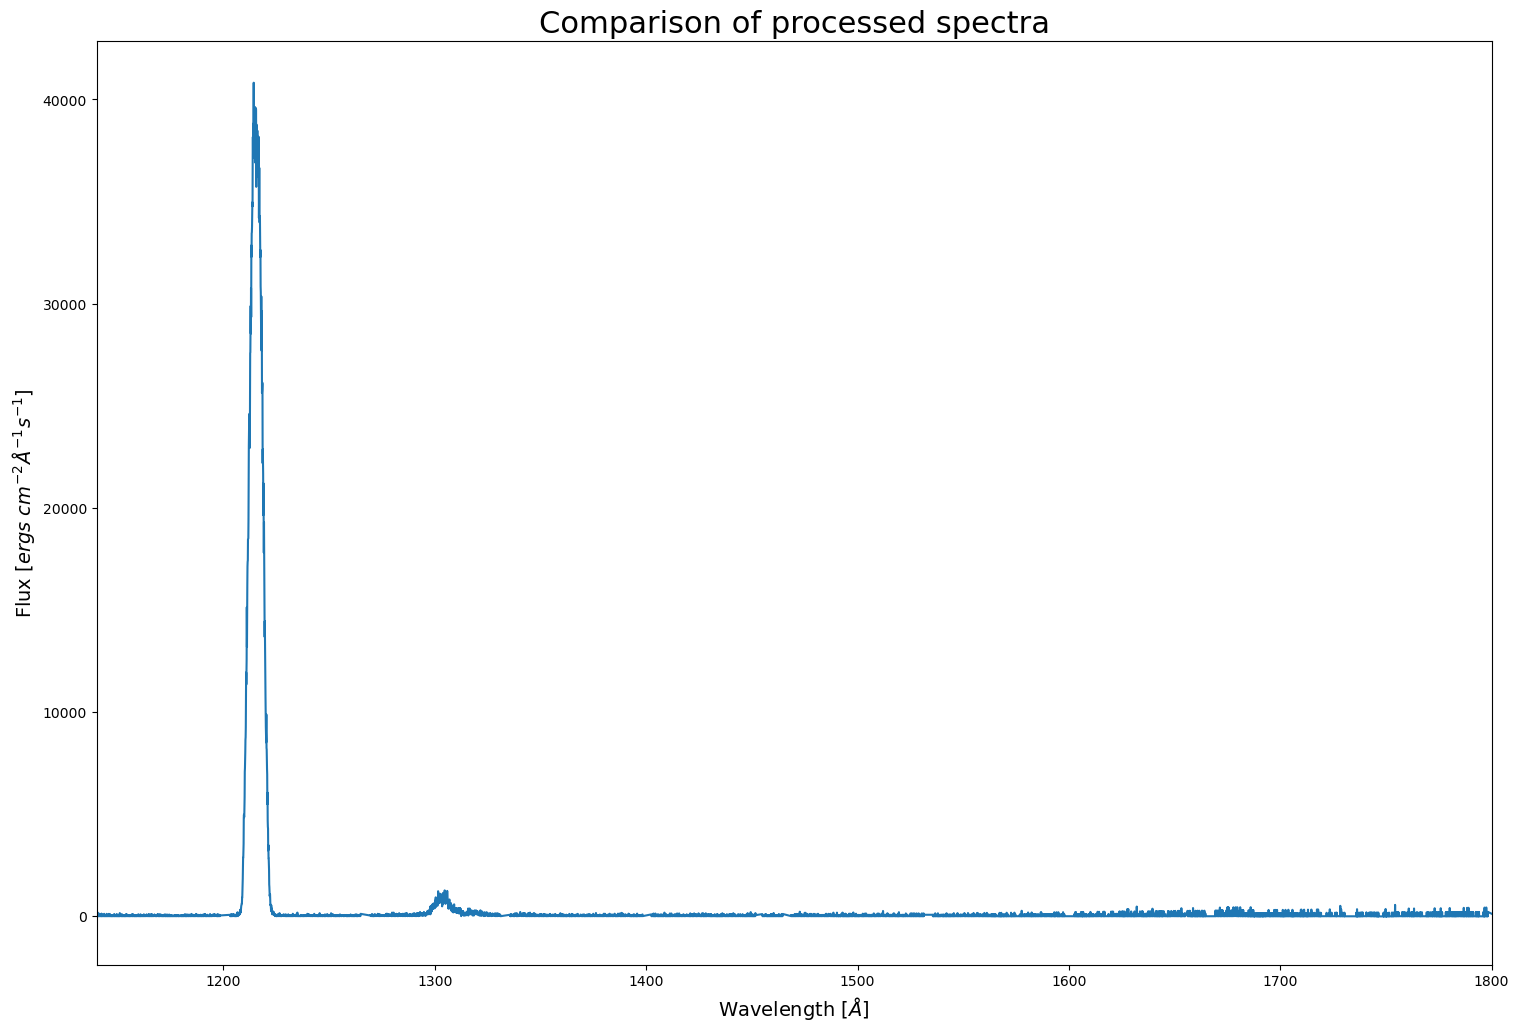

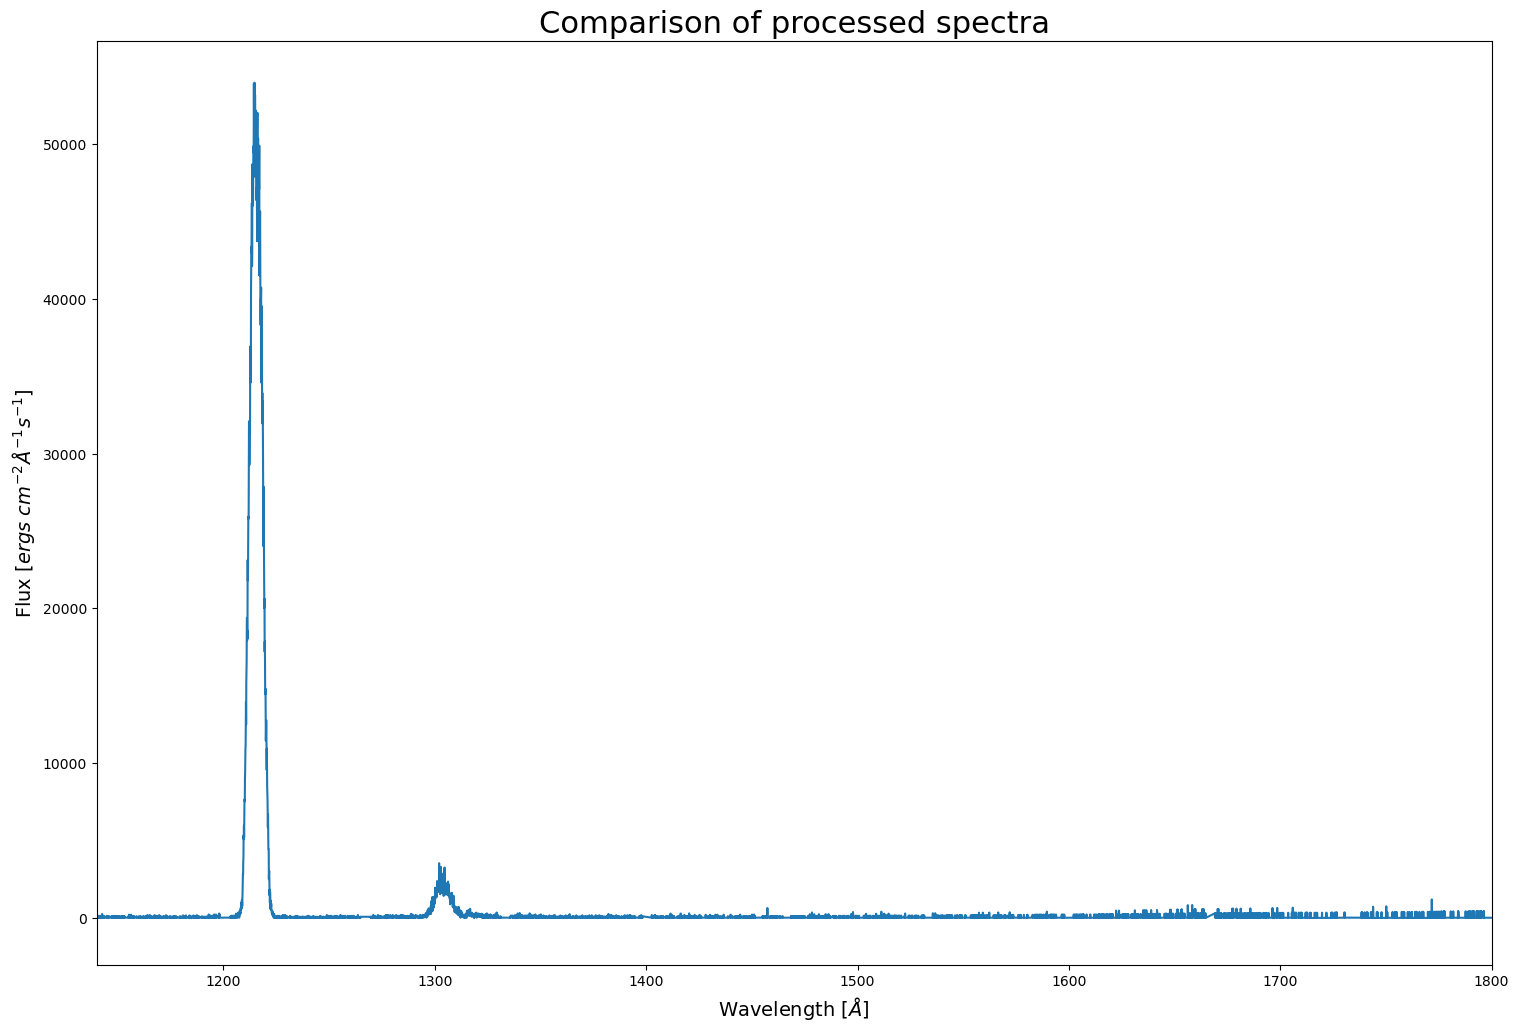

In [20]:
# Find all the `x1d` files:
processed_files = sorted(glob.glob('output/calcos/epoch*/*x1d.fits'))
print(processed_files)

# Set up figure

for i, pfile in enumerate(processed_files):  # Loop through
    plt.figure(figsize=(18, 12))
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UnitsWarning, append=True)
        w, f, ferr, dq = Table.read(pfile)[0]['WAVELENGTH', 'FLUX', 'ERROR', 'DQ']
    dq_mask = np.where(dq == 0) # filter to good quality data
    w, f, ferr = w[dq_mask], f[dq_mask], ferr[dq_mask]
    plt.plot(w, f/1e-17)  # Label with the epoch name

    plt.title("Comparison of processed spectra", size=22)
    plt.xlabel("Wavelength [$\AA$]", size=14)
    plt.ylabel("Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]", size=14)
    plt.xlim(1140, 1800)
    #plt.ylim(-0.01e-13, 0.5e-13)
    plt.show()
    #plt.savefig(plots_dir / f"Compare_spectrum.png", dpi=200)